# Unit Commitment Problem(UCP)

该模型目标是给出满足运营需求情况下，较低的发电成本。根据电力需求，我们打开或关闭具有运行特性和成本的发电装置。机组承诺问题回答了“我应该在什么时间和什么水平运行哪些发电机才能满足电力需求？”

该模型不仅可以帮助用户找到问题的可行答案，还可以优化其解决方案，以尽可能多地满足电力公司的总体目标。


下面数据的co2_cost 存储二氧化碳排放的成本数据；df_units 存储不同种类能源的具体信息；


----------


> https://notebook.community/IBMDecisionOptimization/docplex-examples/examples/mp/jupyter/ucp_pandas
>
> http://ibmdecisionoptimization.github.io/docplex-doc/mp/ucp_pandas.html


In [ ]:
import pandas as pd
import seaborn as sns
import gurobipy as gp
import numpy as np
from gurobipy import GRB

In [1]:

co2_cost = pd.DataFrame({"energy": ["coal", "gas", "diesel", "wind"], "co2_cost": [30, 5, 15, 0]})

df_units = pd.read_csv("./assets/data/unitcommitmentproblem.csv")
df_units = df_units.merge(co2_cost, how = "left", on = "energy")
df_units

,type,energy,initial,min_gen,max_gen,operating_max_gen,min_uptime,min_downtime,ramp_up,ramp_down,start_cost,fixed_cost,variable_cost,co2_cost
0,coal1,coal,400,100.00,425,400,15,9,212.0,183.0,5000,208.610,22.536,30
1,coal2,coal,350,140.00,365,350,15,8,150.0,198.0,4550,117.370,31.985,30
2,gas1,gas,205,78.00,220,205,6,7,101.2,95.6,1320,174.120,70.500,5
3,gas2,gas,52,52.00,210,197,5,4,94.8,101.7,1291,172.750,69.000,5
4,gas3,gas,155,54.25,165,155,5,3,58.0,77.5,1280,95.353,32.146,5
5,gas4,gas,150,39.00,158,150,4,2,50.0,60.0,1105,144.520,54.840,5
6,diesel1,diesel,78,17.40,90,78,3,2,40.0,24.0,560,54.417,40.222,15
7,diesel2,diesel,76,15.20,87,76,3,2,60.0,45.0,554,54.551,40.522,15
8,diesel3,diesel,0,4.00,20,20,1,1,20.0,20.0,300,79.638,116.330,15
9,diesel4,diesel,0,2.40,12,12,1,1,12.0,12.0,250,16.259,76.642,15


In [2]:

raw_demand = [1259.0, 1439.0, 1289.0, 1211.0, 1433.0, 1287.0, 1285.0, 1227.0, 1269.0, 1158.0, 1277.0, 1417.0, 1294.0, 1396.0, 1414.0, 1386.0,
              1302.0, 1215.0, 1433.0, 1354.0, 1436.0, 1285.0, 1332.0, 1172.0, 1446.0, 1367.0, 1243.0, 1275.0, 1363.0, 1208.0, 1394.0, 1345.0, 
              1217.0, 1432.0, 1431.0, 1356.0, 1360.0, 1364.0, 1286.0, 1440.0, 1440.0, 1313.0, 1389.0, 1385.0, 1265.0, 1442.0, 1435.0, 1432.0, 
              1280.0, 1411.0, 1440.0, 1258.0, 1333.0, 1293.0, 1193.0, 1440.0, 1306.0, 1264.0, 1244.0, 1368.0, 1437.0, 1236.0, 1354.0, 1356.0, 
              1383.0, 1350.0, 1354.0, 1329.0, 1427.0, 1163.0, 1339.0, 1351.0, 1174.0, 1235.0, 1439.0, 1235.0, 1245.0, 1262.0, 1362.0, 1184.0, 
              1207.0, 1359.0, 1443.0, 1205.0, 1192.0, 1364.0, 1233.0, 1281.0, 1295.0, 1357.0, 1191.0, 1329.0, 1294.0, 1334.0, 1265.0, 1207.0, 
              1365.0, 1432.0, 1199.0, 1191.0, 1411.0, 1294.0, 1244.0, 1256.0, 1257.0, 1224.0, 1277.0, 1246.0, 1243.0, 1194.0, 1389.0, 1366.0, 
              1282.0, 1221.0, 1255.0, 1417.0, 1358.0, 1264.0, 1205.0, 1254.0, 1276.0, 1435.0, 1335.0, 1355.0, 1337.0, 1197.0, 1423.0, 1194.0, 
              1310.0, 1255.0, 1300.0, 1388.0, 1385.0, 1255.0, 1434.0, 1232.0, 1402.0, 1435.0, 1160.0, 1193.0, 1422.0, 1235.0, 1219.0, 1410.0, 
              1363.0, 1361.0, 1437.0, 1407.0, 1164.0, 1392.0, 1408.0, 1196.0, 1430.0, 1264.0, 1289.0, 1434.0, 1216.0, 1340.0, 1327.0, 1230.0, 
              1362.0, 1360.0, 1448.0, 1220.0, 1435.0, 1425.0, 1413.0, 1279.0, 1269.0, 1162.0, 1437.0, 1441.0, 1433.0, 1307.0, 1436.0, 1357.0, 
              1437.0, 1308.0, 1207.0, 1420.0, 1338.0, 1311.0, 1328.0, 1417.0, 1394.0, 1336.0, 1160.0, 1231.0, 1422.0, 1294.0, 1434.0, 1289.0]
nb_periods = len(raw_demand)
print("nb periods = {}".format(nb_periods))

nb periods = 192


<Axes: >

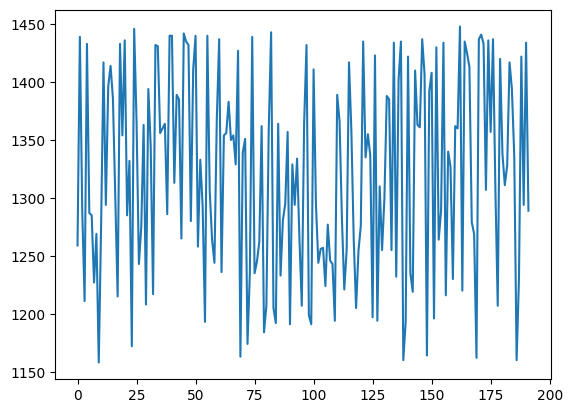

In [3]:
sns.lineplot(raw_demand)

In [19]:



m = gp.Model("UnitCommitmentProblem")


U = df_units.shape[0]
T = nb_periods


x_u_t = m.addMVar((U, T), vtype = GRB.BINARY, name = [[f"x_{a}_{b}" for b in range(T)] for a in range(U) ])
y_on_u_t = m.addMVar((U, T), vtype = GRB.BINARY, name = [[f"yON_{a}_{b}" for b in range(T)] for a in range(U) ])
y_off_u_t = m.addMVar((U, T), vtype = GRB.BINARY, name = [[f"yOFF_{a}_{b}" for b in range(T)] for a in range(U) ])
p_u_t = m.addMVar((U, T), vtype = GRB.CONTINUOUS, name = [[f"p_{a}_{b}" for b in range(T)] for a in range(U)])



fixed_cost = gp.quicksum(x_u_t[i] @ (np.ones((T,), dtype = float) * df_units["fixed_cost"][i]) for i in range(df_units.shape[0]))
var_cost = gp.quicksum(p_u_t[i] @ (np.ones((T,), dtype = float ) * df_units["variable_cost"][i]) for i in range(df_units.shape[0]))
start_up_cost = gp.quicksum(y_on_u_t[i] @ (np.ones((T,), dtype = float ) * df_units["start_cost"][i])  for i in range(df_units.shape[0]))
co2_cost = gp.quicksum(p_u_t[i] @ (np.ones((T,), dtype = float ) * df_units["co2_cost"][i])  for i in range(df_units.shape[0]))
m.setObjective(fixed_cost + var_cost + start_up_cost + co2_cost, GRB.MINIMIZE)


# ========== ADD INITIAL CONSTR ============

for idx in range(U):
    if df_units["initial"][idx] > 0:
        m.addConstr(y_on_u_t[idx, 0] == 0)
        m.addConstr(y_off_u_t[idx, 0] + x_u_t[idx, 0] == 1)
    else:
        m.addConstr(y_on_u_t[idx, 0] == x_u_t[idx, 0])
        m.addConstr(y_off_u_t[idx, 0] == 0)
        
# ========== ADD INITIAL CONSTR ============

# ========== ADD OPERATION LIMIT ============

for idx in range(U):
    for t in range(T):
        m.addConstr(p_u_t[idx, t] <= x_u_t[idx, t] * df_units["max_gen"][idx])
        m.addConstr(p_u_t[idx, t] >= x_u_t[idx, t] * df_units["min_gen"][idx])

# ========== ADD OPERATION LIMIT ============


for idx in range(U):
    for t in range(T - 1):
        
# ========== Stair CONSTR =============
        if t == 0:
            m.addConstr(p_u_t[idx, t] - df_units["initial"][idx] <= df_units["ramp_up"][idx])
            m.addConstr(df_units["initial"][idx] - p_u_t[idx, t] <= df_units["ramp_down"][idx])
        m.addConstr(p_u_t[idx, t + 1] - p_u_t[idx, t] <= df_units["ramp_up"][idx])
        m.addConstr(p_u_t[idx, t] - p_u_t[idx, t + 1] <= df_units["ramp_down"][idx])
# ========== Stair CONSTR =============


# ========== ON / OFF CONSTR =========
        m.addConstr(x_u_t[idx, t + 1] - x_u_t[idx, t] <= y_on_u_t[idx, t + 1])
        m.addConstr(x_u_t[idx, t] - x_u_t[idx, t + 1] + y_on_u_t[idx, t] == y_off_u_t[idx, t + 1])
        # m.addConstr(x_u_t[idx, t] + x_u_t[idx, t + 1] + y_on_u_t[idx, t + 1] <= 2)
# ========== ON / OFF CONSTR =========

# This  constraint is a little bit tough to understand...
for idx in range(U):
    # if df_units["initial"][idx] > 0:
    #     m.addConstr(gp.quicksum(y_off_u_t[idx, z] for z in range(df_units["min_uptime"][idx] - 1)) == 0)
    #     m.addConstr(gp.quicksum(y_on_u_t[idx, z] for z in range(df_units["min_uptime"][idx] - 1)) == 0)
    # else:
    #     m.addConstr(gp.quicksum(y_off_u_t[idx, z] for z in range(df_units["min_downtime"][idx] - 1)) == 0)
    #     m.addConstr(gp.quicksum(y_on_u_t[idx, z] for z in range(df_units["min_downtime"][idx] - 1)) == 0)
    for t in range(df_units["min_uptime"][idx], T):
        # 0 0 0 0 0 
        # 0 1 2 3 4 min = 4
        m.addConstr(gp.quicksum(y_on_u_t[idx, z] for z in range(t - df_units["min_uptime"][idx] + 1, t + 1)) <= x_u_t[idx, t])
    
    for t in range(df_units["min_downtime"][idx], T):
        m.addConstr(gp.quicksum(y_off_u_t[idx, z] for z in range(t - df_units["min_downtime"][idx] + 1, t + 1)) <= 1 - x_u_t[idx, t])

# ========== DEMAND CONSTR ============

for t in range(T):
    m.addConstr(gp.quicksum(p_u_t[idx, t] for idx in range(U)) >= raw_demand[t])

# ========== DEMAND CONSTR ============
# m.write("result.lp")



# =========== SOLVE IT =============

m.optimize()

print(f"Num of Binary Variables: {m.NumBinVars}")
print(f"Num of All Variables: {m.NumVars}")
print(f"Num of All Constrs: {m.NumConstrs}")

if m.status == GRB.Status.OPTIMAL:
    print(f"obj = {m.objVal} ")

else:
    m.computeIIS()
    m.write("model_infeasible.ilp")

# for idx in range(U):
#     for t in range(T):
#         print(p_u_t[idx, t], end = " ")
#     print(" ")
# print(m.Runtime())



Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 15455 rows, 7680 columns and 52222 nonzeros
Model fingerprint: 0x96c99ddf
Variable types: 1920 continuous, 5760 integer (5760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [2e+01, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 8219 rows and 4431 columns
Presolve time: 0.13s
Presolved: 7236 rows, 3249 columns, 20219 nonzeros
Variable types: 1536 continuous, 1713 integer (1713 binary)
Found heuristic solution: objective 1.562128e+07
Found heuristic solution: objective 1.428633e+07

Root relaxation: objective 1.421168e+07, 2446 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

   